In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
MODEL_SAVE_PATH = 'numbers_gen_9_attention_no_embedding'

In [4]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [5]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [6]:
sample_data = all_data.copy()
#sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
#sample_data = sample_data[sample_data['class'] != 'MANUAL']

sample_data =  sample_data[sample_data['class'] == 'NUMBERS']

print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 448170,  (dropped rows: 9470022)


In [7]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['NUMBERS']
1


### Utils stuff

In [8]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [9]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [10]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [11]:
sos_tensor = torch.zeros(1, 1, len(words_after_index))
sos_tensor[0, 0, words_after_index[SOS_TOKEN]] = 1
sos_tensor.size()
#del(onehot_sos)

#sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])


torch.Size([1, 1, 1351])

### More balanced sample

In [12]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_length = 0
def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_accessed_counter/balanced_data_length > 0.2:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

In [13]:
%%timeit
balanced_data_sample_row()

111 µs ± 1.06 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
NUMBERS    20000
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                                               382243
token_id                                                       2
class                                                    NUMBERS
before                                                  May 2013
after                                        may twenty thirteen
class_org                                                   DATE
a_word_ind                                        [66, 6, 49, 0]
sentence       as of <SAMPLE> , georgia glastris is the reign...
Name: 228531, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

NUMBERS : 4 -> four <EOS> [19, 0]
he substituted tim smolders at half time in a 2 - <SAMPLE> home defeat against sporting charleroi .
torch.Size([1, 2, 104])


In [17]:
%%timeit
get_random_sample()

159 µs ± 5.49 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [19]:
MAX_ATTENTION_LENGTH = 20

### Encoder

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)
        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [21]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
list(encoder_output.data.cpu().numpy()) == list(encoder_outputs[len(tmp)].data.cpu().numpy())

'2019'

torch.Size([384])

torch.Size([20, 384])

True

### Decoder

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)

        self.emb_lin = nn.Linear(input_size, hidden_size)
        #self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        #embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.emb_lin(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (emb_lin): Linear (1351 -> 384)
  (attn): Linear (768 -> 20)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

In [23]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 20])]

Variable containing:
 219
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

fiftieth


# Training etc

### Accuracy

In [24]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        #decoder_intput = torch.LongTensor([word_index])
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('sixth idealized idealized synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize',
 'sixth idealized idealized synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize',
 'two thousand three',
 ('2003',
  [5, 8, 13, 0],
  'NUMBERS',
  'gathercole , s . e . , brown , l . , & pickering , s . j . ( <SAMPLE> ) .'))

In [25]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

2009           => idealized idealized idealized synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize || [5, 8, 15, 0] 
                  witte , craeybeckx & meynen <SAMPLE> , p . 306 .
1964           => ireland idealized gamergate synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize synchronize || [7, 39, 19, 0] 
                  initially equipped with 50 lgm - 30 b minuteman is in early <SAMPLE> , the first 90th smw icbm squadron activated .


### Training

In [26]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = torch.zeros(1, 1, len(words_after_index))
        decoder_input[0, 0, word_index] = 1
        decoder_input = Variable(decoder_input).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [27]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0: # or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [28]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/numbers_gen_9_attention_no_embedding_1


In [29]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   7.194   |   7.15: 1945 -> gallons gamergate gamergate gamergate (✗: [7, 41, 14, 0]) 
    18  36% (   0m 0s)   6.958   |   3.08: 12 June 2012 -> nineteen nineteen (✗: [11, 95, 12, 68, 6, 47, 0]) 
    27  54% (   0m 0s)   7.018   |   7.14: II -> nineteen <EOS> (✗: [11, 73, 0]) (forcing)
    36  72% (   0m 0s)   6.729   |   4.76: 20 km -> nineteen (✗: [6, 89, 0]) 
    45  90% (   0m 1s)   6.237   |   0.51: 3-8053-2263-1 ->  (✗: [13, 58, 16, 25, 14, 13, 58, 5, 5, 20, 13, 58, 9, 0]) 


In [30]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 9s)   2.997   |   1.60: 1935 -> nineteen (✗: [7, 34, 14, 0]) 


In [31]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 20s)   2.555   |   3.30: 1390 -> nineteen thousand (✗: [49, 23, 0]) 
  3000  22% (  0m 40s)   2.401   |   0.96: 2 -> two (✓) 
  4000  33% (   1m 0s)   2.291   |   1.54: 1960 -> nineteen sixty three (✗: [7, 39, 0]) 
  5000  44% (  1m 21s)   2.153   |   1.28: 3 -> one (✗: [13, 0]) 
  6000  56% (  1m 42s)   2.056   |   1.70: 29 April 2013 -> the twenty of of <EOS> twenty thousand (✗: [11, 6, 84, 12, 71, 6, 49, 0]) (forcing)
  7000  67% (   2m 2s)   1.968   |   0.94: 1997 -> nineteen eighty seven (✗: [7, 23, 18, 0]) (forcing)
  8000  78% (  2m 23s)   1.885   |   0.86: 1 -> one (✓) (forcing)
  9000  89% (  2m 44s)   1.851   |   1.24: 1986 -> nineteen ninety nine (✗: [7, 27, 20, 0]) 
 10000 100% (   3m 6s)   1.810   |   1.03: 1977 -> nineteen ninety (✗: [7, 33, 18, 0]) 


In [32]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 22s)   0.613   |   1.18: June 2013 -> june twenty twenty (✗: [68, 6, 49, 0]) (forcing)
 30000  22% (  6m 48s)   0.389   |   0.01: 1928 -> nineteen twenty eight (✓) (forcing)
 40000  33% ( 10m 12s)   0.360   |   0.00: 1976 -> nineteen seventy six (✓) 
 50000  44% ( 13m 43s)   0.276   |   0.01: 2011 -> twenty eleven (✓) (forcing)
Saved model to data/models/numbers_gen_9_attention_no_embedding_1/50000_(EncoderRNN/DecoderRNN)
Accuracy: 82.31% (    8231/   10000)
 60000  56% ( 18m 25s)   0.352   |   1.80: 4556 -> four five fifty five (✗: [19, 8, 14, 10, 38, 20, 0]) 
 70000  67% ( 21m 53s)   0.251   |   0.03: 381 -> three hundred eighty one (✓) 
 80000  78% ( 25m 21s)   0.286   |   0.96: 2,988 m -> two thousand eight hundred eighty eight (✗: [5, 8, 15, 10, 27, 16, 108, 0]) 
 90000  89% ( 28m 48s)   0.224   |   0.08: 233 -> two hundred thirty three (✓) (forcing)
100000 100% ( 32m 17s)   0.288   |   0.02: 1917 -> nineteen seventeen (✓) (forcing)
Saved model to data/models/num

In [33]:
print_local_wrong_predictions()

400m           => four hundred   || [19, 10, 108, 0] 
                  " knyazyeva minenko misses medal in moscow ; israeli ends triple jump final in sixth position ; gordon , hejnova take superb <SAMPLE> hurdles golds . "
10460          => ten thousand sixty || [9, 25, 19, 20, 25, 0] 
                  23 hundred southern boulevard , bronx new york <SAMPLE> : wildlife conservation society .
21 Mar 2014    => the twenty first of may twenty fourteen || [11, 6, 56, 12, 62, 6, 50, 0] 
                  retrieved <SAMPLE> .
Friday, February 19, 2010 => february february february february february ninth twelfth || [233, 72, 87, 6, 44, 0] 
                  the washington times — <SAMPLE> retrieved 2015 - 09 - 11 .
978-0-14-118304-6 => nine seven eight sil eight sil eight eight eight sil eight sil eight sil eight sil eight sil eight sil || [15, 18, 16, 58, 25, 58, 9, 19, 58, 9, 9, 16, 13, 25, 19, 58, 20, 0] 
                  isbn <SAMPLE> le livre de l' intranquillité de bernardo soares .


In [34]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110000  20% (  3m 24s)   0.367   |   0.00: 53 -> fifty three (✓) (forcing)
120000  40% (  6m 50s)   0.337   |   0.01: 1656 -> sixteen fifty six (✓) (forcing)
130000  60% ( 10m 17s)   0.329   |   0.00: 19 -> nineteen (✓) (forcing)
140000  80% ( 13m 47s)   0.359   |   0.00: June 7, 2011 -> june seventh twenty eleven (✓) (forcing)
150000 100% ( 17m 14s)   0.361   |   0.02: August 24, 2011 -> august twenty fourth twenty eleven (✓) (forcing)
Saved model to data/models/numbers_gen_9_attention_no_embedding_1/150000_(EncoderRNN/DecoderRNN)
Accuracy: 80.35% (    8035/   10000)


In [35]:
train_iterations(n_iters=50000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

160000  20% (  3m 48s)   0.343   |   0.01: 2003 -> two thousand three (✓) 
170000  40% (  7m 44s)   0.357   |   0.17: 51.6% -> fifty one point six percent (✓) (forcing)
180000  60% ( 11m 35s)   0.320   |   0.02: 1987 -> nineteen eighty seven (✓) 
190000  80% ( 15m 25s)   0.340   |   0.31: 21 September 1950 -> the twenty first of september nineteen fifty five (✗: [11, 6, 56, 12, 64, 7, 38, 0]) 
200000 100% ( 19m 14s)   0.370   |   0.02: 2010 -> twenty ten (✓) (forcing)
Saved model to data/models/numbers_gen_9_attention_no_embedding_1/200000_(EncoderRNN/DecoderRNN)
Accuracy: 79.74% (    7974/   10000)


In [36]:
print_local_wrong_predictions()

6pm            => six p          || [20, 24, 32, 0] 
                  the court adjourned at <SAMPLE> .
2011           => twenty eleven  || [5, 8, 48, 0] 
                  robbie power took over from geraghty as big zeb 's regular jockey for the <SAMPLE> / 2012 national hunt season .
260 m          => two hundred sixty six || [5, 10, 39, 108, 0] 
                  the elevation of the stream at its source is between 840 feet ( <SAMPLE> ) and 860 feet ( 260 m ) .
-60,000        => minus hundred sixty || [119, 39, 8, 0] 
                  the ( red ) mac pro was auctioned for $977 , 000 ( sotheby 's had estimated it would bring $40 , 000 <SAMPLE> ) .
$5             => five           || [14, 85, 0] 
                  it is a margin operation that requires him to pay <SAMPLE> a week for " tuition " .
29/11/2007     => the twenty ninth of february two thousand seven || [11, 6, 84, 12, 69, 5, 8, 18, 0] 
                  " police numbers - <SAMPLE> - qwn " .
December 21, 2008 => december t

In [37]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

KeyboardInterrupt: 

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

In [49]:
tmp = ['a', 'b', 'c']
["{} | {}".format(tmp[i], tmp[-1-i]) for i in range(len(tmp))]

['a | c', 'b | b', 'c | a']

input:   24
output:  ['twenty', 'four']
target:    twenty four


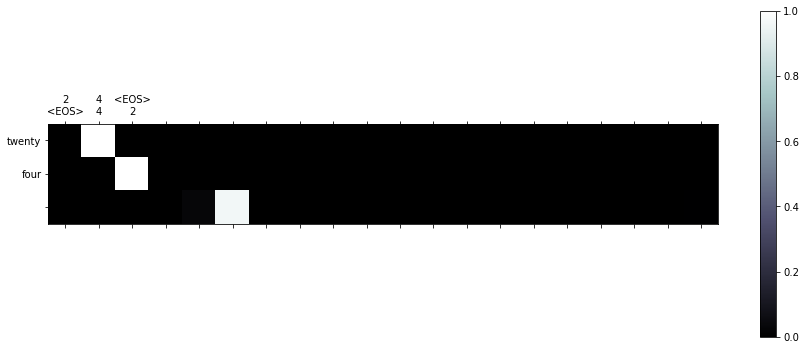

In [99]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    input_sentence = input_sentence + ['<EOS>']
    inp_arr = ["{}\n{}".format(input_sentence[i], input_sentence[-1-i]) for i in range(len(input_sentence))]
    ax.set_xticklabels([''] + inp_arr, rotation=0)
    ax.set_yticklabels([''] + output_words)
    
    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    
    #ax_lab = input_sentence + ['<EOS>']
    #ax_lab = ["{} | {}".format(ax_lab[i], ax_lab[-1-i]) for i in range(len(ax_lab))]
    #ax2.set_xticklabels([''] + ['jaa', 'joo_____'], rotation=0)
    #ax2.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    
    plt.show()
    
def debug_eval_sample_show_attention():
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)
    
debug_eval_sample_show_attention()


In [ ]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)
    
debug_eval_sample_show_attention()
